In [52]:
import numpy as np 
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as mse

In [53]:
#read csv files, there is no ID columns 
X=pd.read_csv("train_features.csv")
y=pd.read_csv("train_targets.csv")
test=pd.read_csv("test_features.csv")

In [54]:
def pre_process(dataframe):
    # to have better understanding on data
    print(dataframe.head())
    print(dataframe.tail())
    print(dataframe.shape)
    print(dataframe.info())

    #convert objects to numerical values sex, smoker, and region 
    dataframe['sex']=dataframe['sex'].map({'female':0, 'male':1})
    dataframe['smoker']=dataframe['smoker'].map({'no':0, 'yes':1})
    dataframe['region']=dataframe['region'].map({'northeast':0, 'southwest':1,'southeast':2, 'northwest':3})
    dataframe.isnull().sum()
    return dataframe
    


In [55]:
#check null values


In [56]:
#overall statistics
X.describe()

,age,bmi,children
count,900.000000,900.000000,900.000000
mean,39.147778,30.692950,1.094444
std,13.920454,6.120561,1.208504
min,18.000000,15.960000,0.000000
25%,27.000000,26.400000,0.000000
50%,39.000000,30.302500,1.000000
75%,51.000000,34.800000,2.000000
max,64.000000,53.130000,5.000000


In [57]:
#do preprocessing on data_frame X
X = pre_process(X)  

   age     sex     bmi  children smoker     region
0   40  female  25.460         1     no  northeast
1   18    male  39.140         0     no  northeast
2   55  female  29.700         2     no  southwest
3   64  female  35.970         0     no  southeast
4   34    male  21.375         0     no  northeast
     age     sex    bmi  children smoker     region
895   50    male  26.41         0     no  northwest
896   23  female  32.78         2    yes  southeast
897   62  female  26.29         0    yes  southeast
898   63    male  21.66         1     no  northwest
899   18  female  21.66         0    yes  northeast
(900, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       900 non-null    int64  
 1   sex       900 non-null    object 
 2   bmi       900 non-null    float64
 3   children  900 non-null    int64  
 4   smoker    900 non-null    obje

split data intrp training and testing sets
train model on training set 
test model on testing set

In [58]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [59]:
#model training 
rf = RandomForestRegressor()
rf.fit(X_train,y_train.values.ravel())
gr = GradientBoostingRegressor()
gr.fit(X_train,y_train.values.ravel())

GradientBoostingRegressor()

In [60]:
y_pred1 = rf.predict(X_test)
y_pred2 = gr.predict(X_test)

df1 = pd.DataFrame({'Actual':y_test.values.flatten(),'rf':y_pred1,'gr':y_pred2})

In [61]:
df1 

,Actual,rf,gr
0,12233.82800,13041.755564,15272.924939
1,4428.88785,13015.598020,7693.051392
2,37133.89820,37539.148188,38119.251057
3,7749.15640,7493.296817,9947.358685
4,4149.73600,7301.814504,5339.125885
...,...,...,...
175,27808.72510,28114.319336,27391.643586
176,6356.27070,12570.796216,7643.484655
177,8782.46900,12784.746522,11046.355330
178,18157.87600,6488.534865,7249.466026


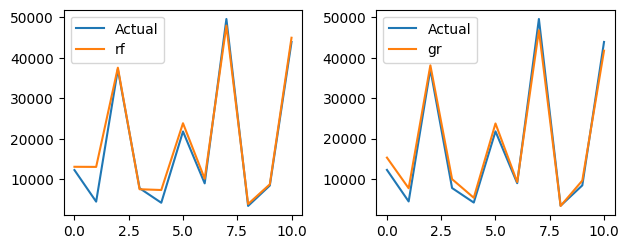

In [63]:
import matplotlib.pyplot as plt

plt.subplot(223)
plt.plot(df1['Actual'].iloc[0:11],label='Actual')
plt.plot(df1['rf'].iloc[0:11],label="rf")
plt.legend()

plt.subplot(224)
plt.plot(df1['Actual'].iloc[0:11],label='Actual')
plt.plot(df1['gr'].iloc[0:11],label="gr")

plt.tight_layout()

plt.legend()


We can see that gradient boosting regressor is better fit.

In [64]:
#function to predict the output of given test sample with with model.

def predict(test, model):
    prediction = model.predict(test) # predicting the data using model
    return prediction

In [65]:
#we got 5 different models from 5Kfold so if we do average calculation over their results, it will improve our success.

def getAveragedPredictions(models, test):
    predictions = []
    for model in models:     
        prediction = predict(X_test_for_submission, model)
        predictions.append(prediction)

    # Get all predictions data togetger to get mean's of every prediction in next step. 
    predictions_new = np.column_stack((predictions[0], predictions[1], predictions[2], predictions[3], predictions[4]))

    # Compute the mean of each row
    averaged_predictions = np.mean(predictions_new, axis=1)
    return averaged_predictions

In [66]:
def write_output(filename,predictions):
    with open(filename, mode='w', newline='') as output_file: # opening file
        output_writer = csv.writer(output_file, delimiter=',') # csv writer
        output_writer.writerow(["ID", "predicted"]) # writning header
        for i in range(len(predictions)):
            output_writer.writerow([i, predictions[i]])

In [67]:
import time

def K5Fold(X, y):
    mseList = [] # list to keep MSEs of each fold
    models = []  # list to store created model in every fold.

    foldNo = 1 # starting fold.

    startTime = time.time() # start time
    kFold = KFold(n_splits=5) # 5-fold CV
    
    
    for train_index, test_index in kFold.split(X):
        X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index] # samples of current fold
        print("Fold: ", foldNo) # printing fold number

        # training the model
        model = GradientBoostingRegressor(loss="huber") 
        model.fit(X_train, y_train.values.ravel())
        prediction = predict(X_test, model) # predicting the test samples
        models.append(model)

        FMse = mse(prediction.flatten(), y_test.to_numpy().flatten()) # calculating MSE of current fold
        print("MSE Result: ", FMse)
        print()
        mseList.append(FMse) # appending fold mse to mse list
        
        foldNo += 1

    print("Total time passed in 5-Fold CV: ","{:.2f}".format((time.time()-startTime))) # printing total time passed
    print("Mean of MSEs:",np.mean(mseList)) # printing the mean of all mses of folds
    return models

# Train and get 5 model from K5Fold
models = K5Fold(X,y) 
print("Training with samples and predicting test samples")
X_test_for_submission = pre_process(test)

# Get predictions from all of 5 model that we got from k5Fold.
averaged_predictions = getAveragedPredictions(models, X_test_for_submission)
  
write_output("predictions.csv", averaged_predictions.flatten()) # writing predictions to csv file
print("Done.")

Fold:  1
MSE Result:  27787092.56704635

Fold:  2
MSE Result:  17000354.02858962

Fold:  3
MSE Result:  22556745.281439696

Fold:  4
MSE Result:  24815586.39118905

Fold:  5
MSE Result:  24121598.632845525

Total time passed in 5-Fold CV:  0.54
Mean of MSEs: 23256275.38022205
Training with samples and predicting test samples
   age     sex     bmi  children smoker     region
0   31  female  25.800         2     no  southwest
1   60    male  24.320         0     no  northwest
2   29    male  28.975         1     no  northeast
3   44    male  31.350         1    yes  northeast
4   43  female  29.900         1     no  southwest
     age     sex     bmi  children smoker     region
433   29    male  35.500         2    yes  southwest
434   62    male  32.110         0     no  northeast
435   33  female  39.820         1     no  southeast
436   37  female  34.105         1     no  northwest
437   40  female  36.190         0     no  southeast
(438, 6)
<class 'pandas.core.frame.DataFrame'>
Ra